In [1]:
uncleaned_filepath = '/content/crop_part1.tar.gz'
cleaned_filepath = '/content/crop_part1_clean.tar.gz'

In [2]:
import os
import tarfile

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

def removefile(filename):
  prefix, ext = os.path.splitext(filename)
  newFilename = 'crop_part1_clean.tar.gz'
  orig = tarfile.open(filename)
  mod = tarfile.open(newFilename, 'w')

  for info in orig.getmembers():
    age_str = info.name.replace('crop_part1/', '').split('_')[0]
    try:
      age = int(age_str)
      extracted = orig.extractfile(info)
      mod.addfile(info, extracted)
    except Exception:
      print(info.name)
      continue
    
  orig.close()
  mod.close()

if not os.path.exists(cleaned_filepath):
  removefile(uncleaned_filepath)

crop_part1


In [3]:
import torch
import torchvision
import torch.utils.tensorboard as tb
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
from skimage import io, transform
import torch.nn as nn
from os import path
import torchtext
import torchvision.models as models
import torch.optim as optim
import cv2

In [4]:
class FaceDataset(Dataset):

  def __init__(self, root_dir, transform=None):
    self.info = torchtext.utils.extract_archive(root_dir)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.info)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    file = self.info[idx]
    image = io.imread(file)
    image = cv2.resize(image, (64, 64))
    image = transforms.ToTensor()(image)

    age = int(file.replace('/content/crop_part1/', '').split('_')[0])
    gender = file.replace('/content/crop_part1/', '').split('_')[1]
    ethnicity = file.replace('/content/crop_part1/', '').split('_')[2]


    if self.transform:
      image = self.transform(image)
    
    return (image, torch.tensor(age))

In [6]:
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomPerspective(interpolation=torchvision.transforms.InterpolationMode.NEAREST),
    transforms.RandomRotation(degrees=30),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data = FaceDataset(cleaned_filepath)
augmented_data = FaceDataset(cleaned_filepath, data_transforms)
combined_data = torch.utils.data.ConcatDataset([data, augmented_data])

## Data Visualization and Utility Functions

9 torch.Size([3, 64, 64])


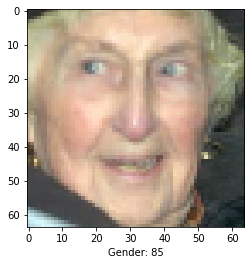

10 torch.Size([3, 64, 64])


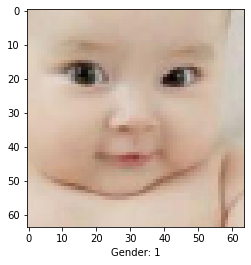

11 torch.Size([3, 64, 64])


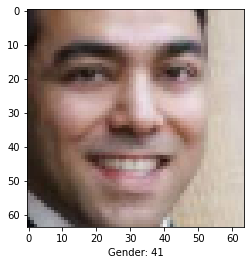

In [8]:
# non augmented images
for i in range(9,12):
    sample = data[i]

    print(i, sample[0].shape)
    plt.xlabel("Gender: {}".format(sample[1]))
    plt.imshow(sample[0].permute(1, 2, 0).numpy())
    plt.show()

9 torch.Size([3, 64, 64])


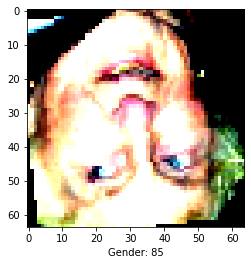

10 torch.Size([3, 64, 64])


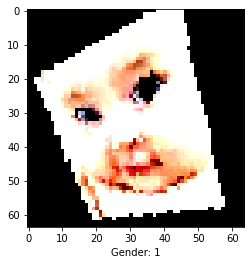

11 torch.Size([3, 64, 64])


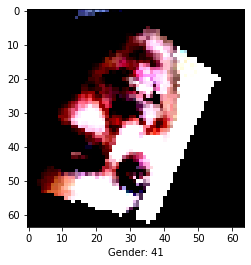

In [9]:
# augmented images
for i in range(9,12):
    sample = augmented_data[i]

    print(i, sample[0].shape)
    plt.xlabel("Gender: {}".format(sample[1]))
    plt.imshow(sample[0].permute(1, 2, 0).numpy())
    plt.show()

In [7]:
combined_data_len = len(combined_data)
# first split train/test with 80/20 split
train, test = torch.utils.data.random_split(combined_data, [int(combined_data_len * .80), int(combined_data_len * .20)])

train1_len = len(train)
# then split train into train/valid with a 75/25 split
train, valid = torch.utils.data.random_split(train, [int(train1_len * .75), int(train1_len * .25)])

In [10]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

def final_score(model, device, test_loader, classes=117):
  model = model.to(device)
  model.eval()
  preds = []
  true = []
  start =  time.time()

  for i, data in enumerate(test_loader):
    inputs, labels = data 
    inputs = inputs.to(device)
    size = inputs.size(0)
    pred = torch.argmax(model(inputs), dim = 1).tolist()
    pred = map(int, pred)
    preds.extend(list(pred))
    true.extend(labels.tolist())

  precision = precision_score(true, preds, average='weighted')
  recall = recall_score(true, preds, average='weighted')
  f1 = f1_score(true, preds, average='weighted')

  cm = confusion_matrix(true, preds)
  df_cm = pd.DataFrame(cm, range(classes), range(classes))

  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(df_cm, annot=True, annot_kws={"size": classes}, ax=ax) # font size
  plt.show()

  end = time.time()

  return precision, recall, f1, (end-start)

In [47]:
def graph_train_valid(train_data, valid_data, title, num):
  epochs = len(train_data)
  plt.plot(range(epochs), train_data, label="training {}".format(title))
  plt.plot(range(epochs), valid_data, label = 'validation {}'.format(title))
  plt.title('Age Model {} {}'.format(num, title))
  plt.xlabel("epochs")
  plt.ylabel(title)
  plt.legend()
  plt.show()

In [13]:
def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

In [15]:
def train(args, save=False):
    device = torch.device("cuda")
    model = args.model.to(device)
    optimizer = optim.Adam(params=model.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step, gamma=0.1, last_epoch=-1, verbose=True)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader, valid_loader = args.train, args.valid 

    train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = [], [], [], []
    if args.init_weight:
      model.apply(init_weights)
      

    for epoch in range(args.epochs):
      model.train()
      train_loss = 0.0
      valid_loss = 0.0
      train_accuracy = 0.0
      valid_accuracy = 0.0
      total_train = 0
      total_val = 0

      for i, data in enumerate(train_loader, 1):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).float().sum() 
        total_train += inputs.size(0)

      for j, data in enumerate(valid_loader, 1):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        valid_loss += (loss.item() * inputs.size(0))
        _, predicted = torch.max(outputs.data, 1)
        valid_accuracy += (predicted == labels).float().sum() 
        total_val += inputs.size(0)
      
      scheduler.step()
      train_loss = train_loss/total_train
      valid_loss = valid_loss/total_val
      train_accuracy = train_accuracy/total_train
      valid_accuracy = valid_accuracy/total_val
      
      train_loss_history.append(train_loss)
      valid_loss_history.append(valid_loss)
      train_acc_history.append(train_accuracy)
      valid_acc_history.append(valid_accuracy)
      print("Training Loss: {} Valid Loss: {} Training Accuracy: {} Valid Accuracy: {}"
      .format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    if save:
      torch.save(model, 'model')

    return (train_loss_history, valid_loss_history, train_acc_history, valid_acc_history)

# Baseline (no classes)

In [16]:
from torchsummary import summary

class BaselineClassifier(nn.Module):
    def __init__(self):
        super(BaselineClassifier, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=0)
        self.fc1 = nn.Linear(3136, 128) 
        self.out = nn.Linear(128, 117) 

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.out(x)
        
        return x

device = torch.device("cuda")
model = BaselineClassifier()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 31, 31]             392
            Conv2d-2           [-1, 16, 14, 14]           2,064
            Linear-3                  [-1, 128]         401,536
            Linear-4                  [-1, 117]          15,093
Total params: 419,085
Trainable params: 419,085
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.08
Params size (MB): 1.60
Estimated Total Size (MB): 1.73
----------------------------------------------------------------


In [ ]:
import torch.optim as optim
class Args(object):
    pass

args1 = Args();
args1.learning_rate = .005
args1.regularization = 5e-4

args1.model = BaselineClassifier()
args1.train = train_loader
args1.valid = valid_loader 
args1.epochs = 10
args1.step = 5
args1.init_weight = True

train_loss, valid_loss, train_accuracy, valid_accuracy = train(args1)

Training Loss: 4.248792505621829 Valid Loss: 4.024916406545659 Training Accuracy: 0.09662576764822006 Valid Accuracy: 0.10812883079051971
Training Loss: 3.9742720931585582 Valid Loss: 3.952417190333329 Training Accuracy: 0.12125085294246674 Valid Accuracy: 0.10838445276021957
Training Loss: 3.8901562297433596 Valid Loss: 3.901379722271473 Training Accuracy: 0.12474437803030014 Valid Accuracy: 0.11886502802371979
Training Loss: 3.840340668275881 Valid Loss: 3.8756723399055026 Training Accuracy: 0.13011248409748077 Valid Accuracy: 0.11860940605401993
Training Loss: 3.7788679453492895 Valid Loss: 3.855133940105789 Training Accuracy: 0.13224267959594727 Valid Accuracy: 0.12372187525033951
Training Loss: 3.7342480945197107 Valid Loss: 3.792517370485333 Training Accuracy: 0.13914451003074646 Valid Accuracy: 0.12678936123847961
Training Loss: 3.6837824645624244 Valid Loss: 3.7608904399754812 Training Accuracy: 0.14221200346946716 Valid Accuracy: 0.12960122525691986
Training Loss: 3.6415073535

In [ ]:
print(train_accuracy[-1].item(), valid_accuracy[-1].item())

0.15337423980236053 0.13087934255599976


# Adjusting For Classes

Using 10 year cutoffs to achieve 12 classes since the ages range from 0-116

In [18]:
class FaceDataset2(Dataset):

  def __init__(self, root_dir, transform=None):
    self.info = torchtext.utils.extract_archive(root_dir)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.info)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    file = self.info[idx]
    image = io.imread(file)
    image = cv2.resize(image, (64, 64))
    image = transforms.ToTensor()(image)

    age = int(file.replace('/content/crop_part1/', '').split('_')[0])
    gender = file.replace('/content/crop_part1/', '').split('_')[1]
    ethnicity = file.replace('/content/crop_part1/', '').split('_')[2]

    age_class = int(math.floor(age/10))
    if self.transform:
      image = self.transform(image)
    
    return (image, torch.tensor(age_class))

In [19]:
data2 = FaceDataset2(cleaned_filepath)
augmented_data2 = FaceDataset2(cleaned_filepath, data_transforms)
combined_data2 = torch.utils.data.ConcatDataset([data2, augmented_data2])


combined_data_len2 = len(combined_data2)
# first split train/test with 80/20 split
train2a, test2 = torch.utils.data.random_split(combined_data2, [int(combined_data_len2 * .80), int(combined_data_len2 * .20)])

train2a_len = len(train2a)
# then split train into train/valid with a 75/25 split
train2, valid2 = torch.utils.data.random_split(train2a, [int(train2a_len * .75), int(train2a_len * .25)])

train_loader2 = DataLoader(train2, batch_size=batch_size, shuffle=True)
valid_loader2 = DataLoader(valid2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test2, batch_size=batch_size, shuffle=True)

In [41]:
from torchsummary import summary

class BaselineClassifier2(nn.Module):
    def __init__(self):
        super(BaselineClassifier2, self).__init__() 
        self.dropout = nn.Dropout(.25)
        self.pool = nn.MaxPool2d((2, 2), (2, 2))

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0)
        self.batch = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(3136, 12) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch(self.conv2(x)))
        x = self.dropout(self.pool(x))

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        
        return x

device = torch.device("cuda")
model = BaselineClassifier2()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           1,568
            Conv2d-2           [-1, 64, 14, 14]          32,832
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
           Dropout-5             [-1, 64, 7, 7]               0
            Linear-6                   [-1, 12]          37,644
Total params: 72,172
Trainable params: 72,172
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.47
Params size (MB): 0.28
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


In [44]:
args_bl2 = Args()
args_bl2.learning_rate = .001
args_bl2.regularization = 5e-4
args_bl2.log_dir = 'logdir' 

args_bl2.model = BaselineClassifier2()
args_bl2.train = train_loader2
args_bl2.valid = valid_loader2
args_bl2.epochs = 15 
args_bl2.init_weight = True
args_bl2.step = 5
train_loss_bl2, valid_loss_bl2, train_accuracy_bl2, valid_accuracy_bl2 = train(args_bl2)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.144006628687884 Valid Loss: 1.9053104803849827 Training Accuracy: 0.31194615364074707 Valid Accuracy: 0.349693238735199
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 1.909022632714592 Valid Loss: 1.752530209857262 Training Accuracy: 0.3495228588581085 Valid Accuracy: 0.38215744495391846
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 1.8092451293856902 Valid Loss: 1.712064188194665 Training Accuracy: 0.3705691993236542 Valid Accuracy: 0.3941717743873596
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 1.732154470929989 Valid Loss: 1.7044503703439162 Training Accuracy: 0.39255285263061523 Valid Accuracy: 0.40030673146247864
Adjusting learning rate of group 0 to 1.0000e-04.
Training Loss: 1.6885236669090546 Valid Loss: 1.6140842588888844 Training Accuracy: 0.4020109176635742 Valid Accuracy: 0.44861963391304016
Adjusting l

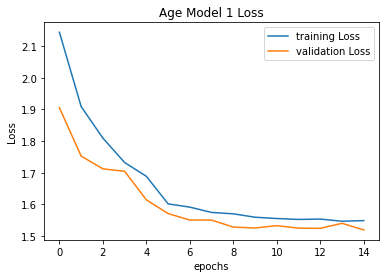

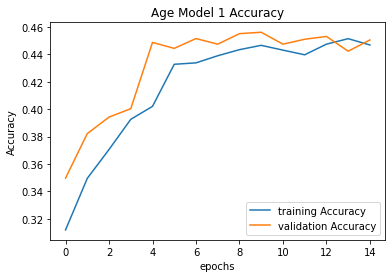

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


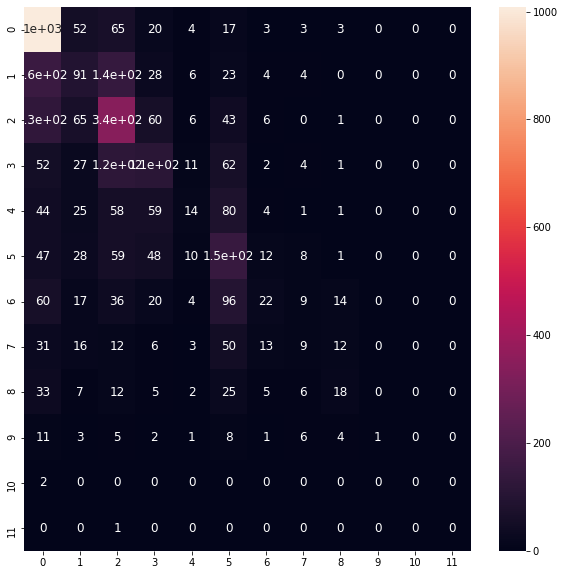

Test Precision: 0.4142482880007664 Test Recall: 0.4527096114519427 Test F1: 0.40923983270935166 Total Time: 9.710124254226685 seconds


In [48]:
graph_train_valid(train_loss_bl2, valid_loss_bl2, 'Loss', 1)
graph_train_valid(train_accuracy_bl2, valid_accuracy_bl2, 'Accuracy', 1)
precision_bl2, recall_bl2, f1_bl2, time_bl2 = final_score(args_bl2.model, device, test_loader2, 12)
print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision_bl2, recall_bl2, f1_bl2, time_bl2))

In [20]:
class AgeClassifier2(nn.Module):
    def __init__(self):
        super(AgeClassifier2, self).__init__() 
        self.dropout = nn.Dropout(.25)
        self.pool1 = nn.MaxPool2d((2, 2), (2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, bias=True)
        self.batch1 = nn.BatchNorm2d(96)

        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, bias=False)
        self.batch2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, bias=False)
        self.batch3 = nn.BatchNorm2d(384)

        self.conv4 = nn.Conv2d(in_channels=384, out_channels=512, kernel_size=3, stride=1, bias=False)
        self.batch4 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(in_features=512, out_features=12, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(self.pool1(self.batch1(x)))

        x = F.relu(self.conv2(x))
        x = self.dropout(self.pool2(self.batch2(x)))

        x = F.relu(self.conv3(x))
        x = self.dropout(self.pool2(self.batch3(x)))

        x = F.relu(self.conv4(x))
        x = self.dropout(self.pool2(self.batch4(x)))

        x = torch.flatten(x, 1)
        x = self.dropout(self.fc1(x))

        return x

device = torch.device("cuda")
model = AgeClassifier2()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 60, 60]           7,296
       BatchNorm2d-2           [-1, 96, 60, 60]             192
         MaxPool2d-3           [-1, 96, 30, 30]               0
           Dropout-4           [-1, 96, 30, 30]               0
            Conv2d-5          [-1, 256, 26, 26]         614,400
       BatchNorm2d-6          [-1, 256, 26, 26]             512
         MaxPool2d-7          [-1, 256, 13, 13]               0
           Dropout-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 11, 11]         884,736
      BatchNorm2d-10          [-1, 384, 11, 11]             768
        MaxPool2d-11            [-1, 384, 5, 5]               0
          Dropout-12            [-1, 384, 5, 5]               0
           Conv2d-13            [-1, 512, 3, 3]       1,769,472
      BatchNorm2d-14            [-1, 51

In [49]:
args2 = Args()
args2.learning_rate = .001
args2.regularization = 5e-4
args2.log_dir = 'logdir' 

args2.model = AgeClassifier2()
args2.train = train_loader2
args2.valid = valid_loader2
args2.epochs = 45 
args2.init_weight = True
args2.step = 10
train_loss2, valid_loss2, train_accuracy2, valid_accuracy2 = train(args2)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.5517184562072024 Valid Loss: 1.8498052597533463 Training Accuracy: 0.24599523842334747 Valid Accuracy: 0.3502044975757599
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.124544269955719 Valid Loss: 1.7611841994560569 Training Accuracy: 0.31756988167762756 Valid Accuracy: 0.3744887411594391
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 1.8631613926572221 Valid Loss: 1.643184719397734 Training Accuracy: 0.3776414692401886 Valid Accuracy: 0.401840478181839
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 1.7551110326309307 Valid Loss: 1.5210144541746269 Training Accuracy: 0.4005623757839203 Valid Accuracy: 0.46293455362319946
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 1.6787248219286575 Valid Loss: 1.9041582765267182 Training Accuracy: 0.4288514256477356 Valid Accuracy: 0.3358895480632782
Adjusting 

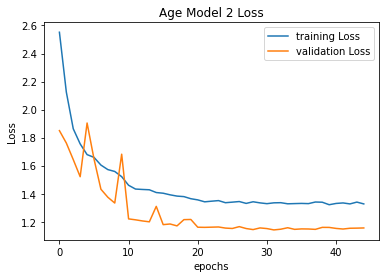

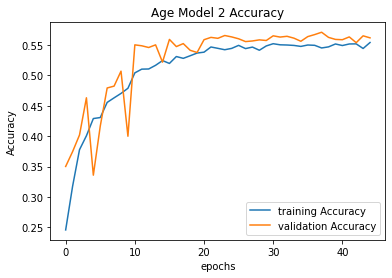

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


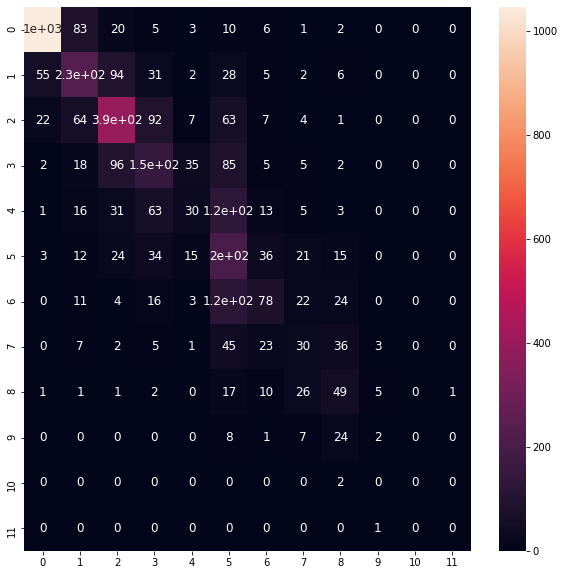

Test Precision: 0.5741535926009784 Test Recall: 0.5639059304703476 Test F1: 0.5592220178438755 Total Time: 9.915400743484497 seconds


In [52]:
graph_train_valid(train_loss2, valid_loss2, 'Loss', 2)

graph_train_valid(train_accuracy2, valid_accuracy2, 'Accuracy', 2)

precision2, recall2, f1_2, time2 = final_score(args2.model, device, test_loader2, 12)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision2, recall2, f1_2, time2))

# Transfer Learning

In [30]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# add dropout to prevent overfitting 
model.fc = nn.Sequential(
     nn.Dropout(.25),
     nn.Linear(model.fc.in_features, 12)
)

# only fine tune last layer 
for param in model.parameters():
  if i == 160:
    param.requires_grad = True
  else:
    param.requires_grad = False
  i += 1

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [32]:
class Args(object):
    pass

args_tl = Args();
args_tl.learning_rate = 0.001
args_tl.regularization = .001

args_tl.train = train_loader2
args_tl.valid = valid_loader2
args_tl.epochs = 25
args_tl.init_weight = False
args_tl.step = 10

args_tl.model = model

train_loss_tl, valid_loss_tl, train_accuracy_tl, valid_accuracy_tl = train(args_tl)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.3849003963431454 Valid Loss: 2.2609461382610423 Training Accuracy: 0.16862645745277405 Valid Accuracy: 0.24079753458499908
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.2482988801876864 Valid Loss: 2.16265586183115 Training Accuracy: 0.2539195716381073 Valid Accuracy: 0.2816973328590393
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.174247147196722 Valid Loss: 2.1218271070219012 Training Accuracy: 0.27709612250328064 Valid Accuracy: 0.28093045949935913
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.1310484734374646 Valid Loss: 2.084309442399226 Training Accuracy: 0.2811861038208008 Valid Accuracy: 0.2903885543346405
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 2.119263780385195 Valid Loss: 2.068027500238399 Training Accuracy: 0.2865541875362396 Valid Accuracy: 0.29089978337287903
Adjusting l

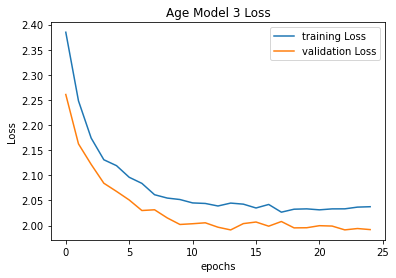

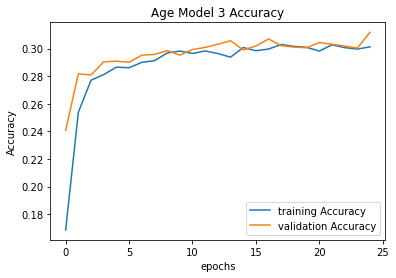

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


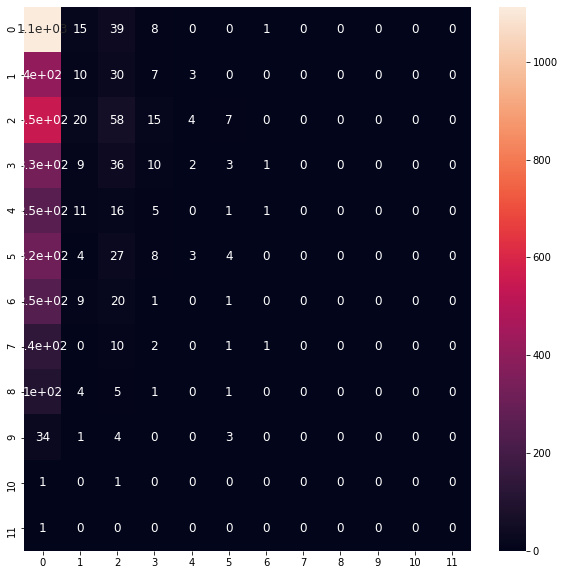

Test Precision: 0.184346691519196 Test Recall: 0.3052147239263804 Test F1: 0.17547604766941907 Total Time: 11.540324449539185 seconds


In [55]:
graph_train_valid(train_loss_tl, valid_loss_tl, 'Loss', 3)

graph_train_valid(train_accuracy_tl, valid_accuracy_tl, 'Accuracy', 3)

precision_tl, recall_tl, f1_tl, time_tl = final_score(args_tl.model, device, test_loader2, 12)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision_tl, recall_tl, f1_tl, time_tl))